In [98]:
import pandas as pd
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

import sklearn.datasets
from sklearn.model_selection import cross_val_score
import time
import scipy.stats as stats

from sklearn.model_selection import RandomizedSearchCV

# Import a dataset

In [3]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

In [5]:
dataset.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [ ]:
kernel = GPy.kern.RBF(input_dim=1, variance=1.5, lengthscale=2.)

In [75]:
def objective_function(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
                     X, y, scoring='neg_mean_squared_error',
                     cv=10).mean()
    score = np.array(score)
    return score

In [43]:
baseline = cross_val_score(
                            XGBRegressor(), 
                            X, 
                            y, 
                            scoring='neg_mean_squared_error',
                            cv=10).mean()
baseline

-3440.623832128542

In [68]:
XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [44]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 100)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 500)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [87]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective_function, domain=bounds,
    acquisition_type ='EI',
    acquisition_jitter = 0.9,
    exact_feval=True,
    maxmimise=True)

In [88]:
max_iter = 200
max_time = 360
optimizer.run_optimization(max_iter, max_time)

In [113]:
n_iters = len(optimizer.Y)

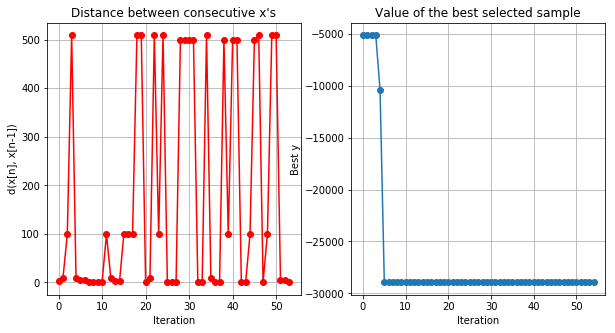

In [89]:
optimizer.plot_convergence()

In [90]:
optimizer.plot_acquisition()

In [91]:
print('MSE:', np.max(optimizer.Y),
      'Gain:', (baseline/np.max(optimizer.Y)*100)-100)

MSE: -3115.620506517548 Gain: 10.431415666032535


In [92]:
optimizer.X[np.argmin(optimizer.Y)]

array([  0.,   0., 100.,   1.,  10.])

# Compare against Random Search

In [96]:
param_dist =  {'learning_rate': stats.uniform(0, 1),
    'gamma': stats.uniform(0, 5),
    'max_depth': list(range(1, 100)),
    'n_estimators': list(range(1, 500)),
    'min_child_weight': list(range(1, 10))}

In [115]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
    return results

In [116]:
# specify parameters and distributions to sample from
# param_dist = {'average': [True, False],
#               'l1_ratio': stats.uniform(0, 1),
#               'alpha': loguniform(1e-4, 1e0)}

# run randomized search
n_iter_search = n_iters
clf = XGBRegressor(scoring='neg_mean_squared_error')
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                  scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
results = report(random_search.cv_results_)

RandomizedSearchCV took 43.58 seconds for 55 candidates parameter settings.
Model with rank: 1
Mean validation score: -3119.314 (std: 122.668)
Parameters: {'gamma': 1.9793441316959575, 'learning_rate': 0.34043059164881495, 'max_depth': 1, 'min_child_weight': 7, 'n_estimators': 86}

Model with rank: 2
Mean validation score: -3656.991 (std: 319.653)
Parameters: {'gamma': 2.703126142933674, 'learning_rate': 0.08667038951245054, 'max_depth': 67, 'min_child_weight': 6, 'n_estimators': 39}

Model with rank: 3
Mean validation score: -3701.614 (std: 241.139)
Parameters: {'gamma': 2.924485756208757, 'learning_rate': 0.12980306223000393, 'max_depth': 66, 'min_child_weight': 8, 'n_estimators': 216}

Model with rank: 4
Mean validation score: -3830.717 (std: 351.988)
Parameters: {'gamma': 2.035198375084013, 'learning_rate': 0.16831443890821673, 'max_depth': 35, 'min_child_weight': 6, 'n_estimators': 459}

Model with rank: 5
Mean validation score: -3839.888 (std: 234.393)
Parameters: {'gamma': 2.525

 /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [126]:
best = np.flatnonzero(results['rank_test_score'] == 1)

In [127]:
random_best_score = results['mean_test_score'][best]

In [130]:
best.tolist()

[6]

In [135]:
results['params'][best[0]]

{'gamma': 1.9793441316959575,
 'learning_rate': 0.34043059164881495,
 'max_depth': 1,
 'min_child_weight': 7,
 'n_estimators': 86}

In [136]:
print('MSE:', random_best_score,
      'Gain:', (baseline/random_best_score*100)-100)

MSE: [-3119.31435655] Gain: [10.30064427]


In [ ]:
print('MSE:', random_best_score,
      'Gain:', (np.max(optimizer.Y)/random_best_score*100)-100)